# Facial Detection and Data Generation

In [1]:
# import the necessary packages
import numpy as np
import cv2
from combine import deep_convert

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [25]:
image = "https://storage.googleapis.com/projectm_web/_pshkeiq6b3.jpg"

In [4]:
image = "/Users/erikni/Downloads/New Training Data as of 10052018/30251 Sad.png"

In [26]:
def convert_single_img(input_img):
    try:
        temp_out = deep_convert(input_img, pic_id = 0, return_rectangle = True, save_img=False)
        
        width = temp_out[1][1] - temp_out[1][0]
        height = temp_out[1][3] - temp_out[1][2]
        temp_out[1][0] += round(width * 0.15)
        temp_out[1][1] -= round(width * 0.15)
        temp_out[1][2] += round(height * 0.15)
        temp_out[1][3] -= round(height * 0.15)
        
    except:
        print("fail to find the front face")
        
    return temp_out

In [23]:
temp_out = deep_convert(image, pic_id = 0, return_rectangle = True, save_img=False)

In [24]:
print(temp_out)

(array([204, 204, 204, ...,  21,  24,  32], dtype=uint8), [0, 532, 35, 567, 542])


In [28]:
from webimg import url_to_image
import urllib.request


In [27]:
def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()))
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    return image

In [15]:
resp = urllib.request.urlopen(image)
image = np.asarray(bytearray(resp.read()))
image = cv2.imdecode(image, cv2.IMREAD_COLOR)


In [21]:
image = np.asarray(bytearray(resp.read()))
image.shape

(0,)

In [31]:
def image_shown(image):
    """
    CV2 package use BGR, matplotlib use RGB
    """
    try:
        temp_out = convert_single_img(image)
    except:
        None
    img = url_to_image(image)
    left, right, up, down = temp_out[1][0:4]
    green = (0, 255, 0)
    cv2.rectangle(img, (left, up), (right, down), green, thickness=3)
    cv2.imwrite("outputimage.jpg", img)
    img=mpimg.imread("outputimage.jpg")
    plt.imshow(img)

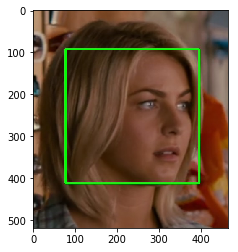

In [32]:
image_shown(image)

In [8]:
test_img_data = convert_single_img(image)[0].reshape(200,200)

In [9]:
# convert np data type into int data type for json

push_data = []
for i in test_img_data:
    row = []
    for j in i:
        row.append([int(j)])
    push_data.append(row)
"""
for i in test_img_data:
    push_data.append(int(i))
"""


'\nfor i in test_img_data:\n    push_data.append(int(i))\n'

In [10]:
push_data_np = np.array(push_data)

In [11]:
# need a 1*200*200*1 input
push_data_np.shape

(200, 200, 1)

# Use Rest API to Get Prediction

In [12]:
import requests
import json

In [13]:
url = "http://35.224.178.33:8501/v1/models/my_model/versions/1"

In [14]:
r = requests.get(url)
print (r)

<Response [400]>


In [15]:
# convert data into json
data = {"instances":[push_data]}

push_data_json = json.dumps(data, sort_keys=True, separators=(',', ': '))

"""
with open('data.json', 'w') as outfile:
    json.dump(push_data_json, outfile)
"""
# print(push_data_json)

"\nwith open('data.json', 'w') as outfile:\n    json.dump(push_data_json, outfile)\n"

In [16]:
# requests via REST API
r = requests.post("http://35.224.178.33:8501/v1/models/keras1014:predict", data=push_data_json)
print(r.text)

{
    "predictions": [[0.1191, 0.122806, 0.128655, 0.118592, 0.131906, 0.117546, 0.130681, 0.130712]
    ]
}
